In [52]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
%autoreload 2

In [54]:
"""
This module is designed to visualise the outputs of the simulator
"""
import orekit
from opssat.env import OPSSATEnv
from opssat.sat import OPSSAT
from simulator.main import Simulator

import orekit
from orekit.pyhelpers import setup_orekit_curdir
from orekit.pyhelpers import absolutedate_to_datetime 

from org.orekit.frames import FramesFactory
from org.orekit.orbits import KeplerianOrbit
from org.orekit.time import AbsoluteDate
from org.orekit.time import TimeScalesFactory
from org.orekit.utils import Constants, IERSConventions, AngularDerivativesFilter
from org.orekit.utils import PVCoordinates
from org.hipparchus.geometry.euclidean.threed import Vector3D

import numpy as np

In [55]:
from org.orekit.models.earth import GeoMagneticFieldFactory
vm = orekit.initVM()
setup_orekit_curdir(filename="orekit-data")
year = 2014.0

GeoMagneticFieldFactory.getIGRF(year)

<GeoMagneticField: org.orekit.models.earth.GeoMagneticField@7465860c>

In [56]:
def create_orbit(initialDate: AbsoluteDate):
    position  = Vector3D(-6142438.668, 3492467.560, -25767.25680)
    velocity  = Vector3D(505.8479685, 942.7809215, 7435.922231)
    initialOrbit =  KeplerianOrbit(PVCoordinates(position, velocity),
                                                            FramesFactory.getEME2000(), initialDate,
                                                            Constants.EIGEN5C_EARTH_MU)
    return initialOrbit

In [57]:
vm = orekit.initVM()
setup_orekit_curdir()
start_date = AbsoluteDate(2014, 1, 1, 23, 30, 00.000, TimeScalesFactory.getUTC())
orbit = create_orbit(start_date)
opssat = OPSSAT(orbit=orbit)
env = OPSSATEnv()
simulator = Simulator(satellite=opssat, orbit=orbit, env=env, step_size=60.0 * 60)
end_date = AbsoluteDate(2014, 2, 1, 23, 40, 00.000, TimeScalesFactory.getUTC())
res = simulator.run(end_date)

SpacecraftState{orbit=Keplerian parameters: {a: 7069220.386682823; e: 4.777356060557311E-4; i: 98.18525099174988; pa: 13.741061002484528; raan: 150.34825333049; v: -13.952151446378437;}, attitude=org.orekit.attitudes.Attitude@734b2c57, mass=5.777673, additional={}}


In [58]:
res["state"][0]

<SpacecraftState: SpacecraftState{orbit=Keplerian parameters: {a: 7069220.386682823; e: 4.777356060557311E-4; i: 98.18525099174988; pa: 13.741061002484528; raan: 150.34825333049; v: -13.952151446378437;}, attitude=org.orekit.attitudes.Attitude@734b2c57, mass=5.777673, additional={}}>

In [59]:
from math import radians, pi
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint
from org.orekit.frames import FramesFactory, TopocentricFrame

ITRF = FramesFactory.getITRF(IERSConventions.IERS_2010, True)
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                         Constants.WGS84_EARTH_FLATTENING, 
                         ITRF)

In [60]:
longitude = radians(21.063)
latitude  = radians(67.878)
altitude  = 341.0
station1 = GeodeticPoint(latitude, longitude, altitude)
sta1Frame = TopocentricFrame(earth, station1, "Esrange")

In [61]:
import pandas as pd

inertialFrame = FramesFactory.getEME2000()

pvs = list(map(lambda x: x.getPVCoordinates(), res["state"]))

prop_data = pd.DataFrame(data=pvs, columns=['pv'])

prop_data['Position'] = prop_data['pv'].apply(lambda x: x.getPosition())
prop_data['datetime'] = prop_data['pv'].apply(lambda x: absolutedate_to_datetime(x.getDate()))
prop_data['elevation'] = prop_data['pv'].apply(lambda x: sta1Frame.getElevation(x.getPosition(), inertialFrame, x.getDate())*180.0/pi )
prop_data['azimuth'] = prop_data['pv'].apply(lambda x: sta1Frame.getAzimuth(x.getPosition(), inertialFrame, x.getDate())*180.0/pi )
prop_data.set_index('datetime', inplace=True, drop=False)
prop_data.index.name = 'Timestamp'

In [62]:
prop_data.head() 

,pv,Position,datetime,elevation,azimuth
Timestamp,,,,,
2014-01-01 23:30:00,"{2014-01-01T23:30:00.000, P(-6142438.668, 3492...","{-6,142,438.668; 3,492,467.56; -25,767.2568}",2014-01-01 23:30:00,-32.142386,142.433723
2014-01-01 23:40:00,"{2014-01-01T23:40:00.000, P(-9.044052536074705...","{-90,440,525.36074705; 296,416,256.52368015; -...",2014-01-01 23:40:00,-12.436769,188.946941
2014-01-01 23:50:00,"{2014-01-01T23:50:00.000, P(-1.771628635512856...","{-177,162,863.5512856; 595,840,074.926729; -41...",2014-01-01 23:50:00,-12.331295,191.410166
2014-01-02 00:00:00,"{2014-01-02T00:00:00.000, P(-2.638929870104982...","{-263,892,987.01049826; 895,280,537.1555716; -...",2014-01-02 00:00:00,-12.447175,193.645814
2014-01-02 00:10:00,"{2014-01-02T00:10:00.000, P(-3.506250098537009...","{-350,625,009.8537009; 1,194,725,076.310812; -...",2014-01-02 00:10:00,-12.643689,195.823472


In [63]:
prop_data['groundpoint'] = prop_data['pv'].apply(lambda pv: earth.transform(pv.position, inertialFrame, pv.date))
prop_data['latitude'] = np.degrees(prop_data.groundpoint.apply(lambda gp: gp.latitude))
prop_data['longitude'] = np.degrees(prop_data.groundpoint.apply(lambda gp: gp.longitude))
prop_data['day'] = prop_data.datetime.dt.dayofyear
prop_data['hour'] = prop_data.datetime.dt.hour

In [64]:
prop_data['visible'] = prop_data.elevation.apply(lambda el: 'Yes' if el>0 else 'No') 

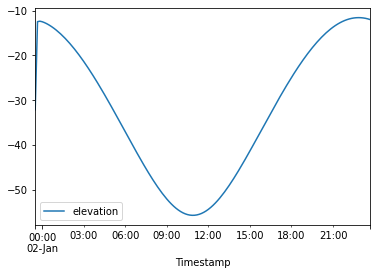

In [65]:
prop_data.plot(y='elevation'); 

In [66]:
import plotly.express as px 

In [67]:
px.line(prop_data, y='elevation', x='datetime', hover_name="datetime", 
        hover_data=['azimuth',
                    'elevation',
                    'latitude',
                    'longitude'])

In [68]:
px.scatter_geo(prop_data,
               animation_frame='hour',
               color='visible',
               lat='latitude',
               lon='longitude',
               opacity=0.3,
               hover_data=['elevation', 'azimuth'],
           projection='orthographic',)